In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

In [2]:
# !pip install matplotlib wordcloud

#### Reading Animelist.csv

In [3]:
import os

In [4]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [5]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=["user_id", "anime_id", "rating"])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
len(rating_df)

5000000

#### Data Processing

In [8]:
n_ratings = rating_df["user_id"].value_counts()

In [9]:
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [10]:
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings>=400].index)].copy()

In [11]:
rating_df.shape

(3246641, 3)

In [12]:
min_rating = rating_df['rating'].min()
max_rating = rating_df['rating'].max()
avg_rating = rating_df['rating'].mean()

In [13]:
max_rating

np.int64(10)

In [14]:
avg_rating

np.float64(4.122732695114736)

In [15]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x - min_rating)/(max_rating - min_rating)).values.astype(np.float64)

In [16]:
rating_df['rating'].min()

np.float64(0.0)

In [17]:
rating_df['rating'].max()

np.float64(1.0)

In [18]:
rating_df['rating'].mean()

np.float64(0.4122732695114729)

In [19]:
rating_df.duplicated().sum()

np.int64(0)

In [20]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [21]:
user_ids = rating_df['user_id'].unique().tolist()
user2user_encoded = {x:i for i, x in enumerate(user_ids)}

In [22]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [23]:
user2user_decoded = {i:x for i, x in enumerate(user_ids)}

In [24]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [25]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [26]:
n_users = len(user2user_encoded)
n_users

4203

In [27]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x:i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i:x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [28]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [29]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [30]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [31]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [32]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [33]:
len(X_train), len(X_test)

(3245641, 1000)

In [34]:
type(X_train)

numpy.ndarray

In [35]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [36]:
type(X_train_array)

list

In [37]:
type(X_train_array[0])

numpy.ndarray

#### MODEL ARCHITECTURE

In [38]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])

    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=["mae", "mse"], optimizer='Adam')
    return model


In [39]:
model = RecommenderNet()

In [40]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [41]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr)/ramup_epochs*epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr

In [42]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
                                   monitor='val_loss', mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

In [43]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [44]:
history = model.fit(x=X_train_array, 
                    y=y_train, 
                    batch_size=batch_size, 
                    epochs=20, 
                    verbose=1, 
                    validation_data=(X_test_array, y_test), 
                    callbacks=my_callbacks)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.7932 - mae: 0.3806 - mse: 0.1949 - val_loss: 0.7161 - val_mae: 0.3662 - val_mse: 0.1666 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.7903 - mae: 0.3796 - mse: 0.1938 - val_loss: 0.7831 - val_mae: 0.3807 - val_mse: 0.1923 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.7849 - mae: 0.3775 - mse: 0.1916 - val_loss: 0.7932 - val_mae: 0.3827 - val_mse: 0.1955 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.7765 - mae: 0.3741 - mse: 0.1882 - val_loss: 0.7897 - val_mae: 0.3820 - val_mse: 0.1942 - learning_rate: 3.4000e-05


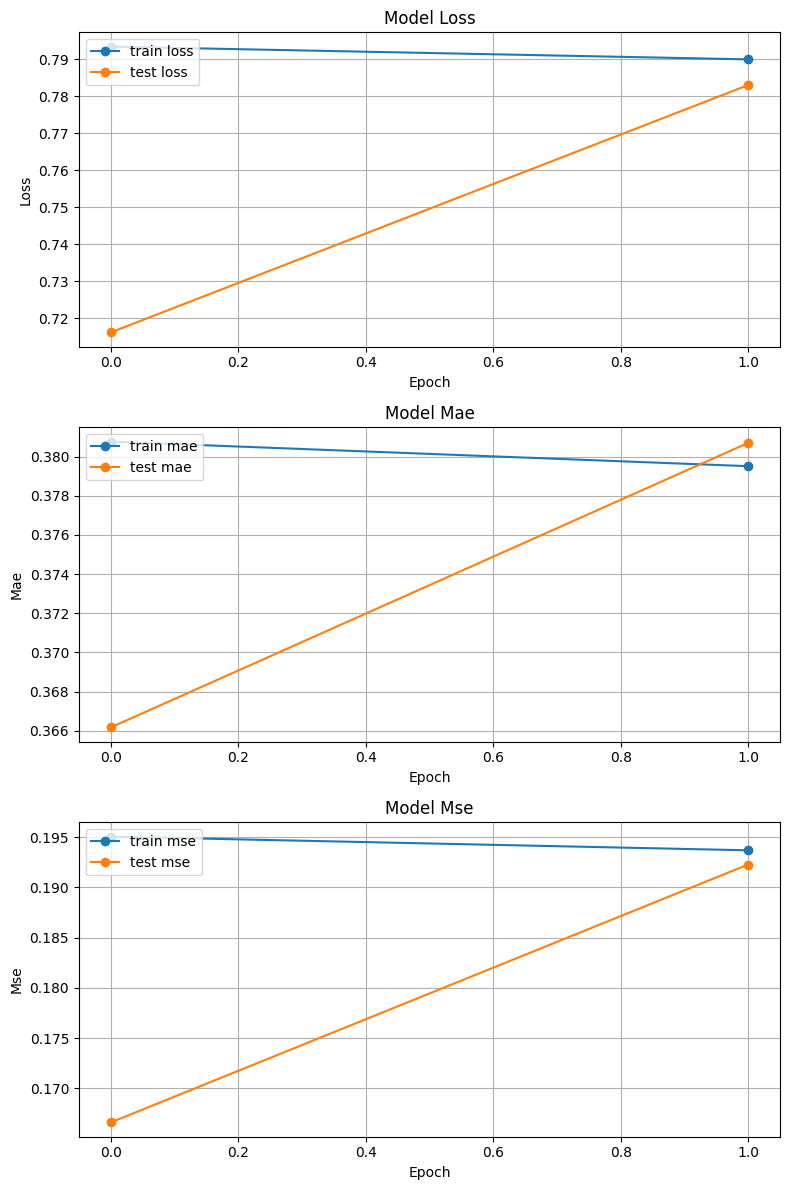

In [45]:
metrics = ["loss", "mae", "mse"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*4))

for i , metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [46]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape(-1, 1)
    return weights

In [47]:
anime_weights = extract_weights("anime_embedding", model=model)

In [48]:
user_weights = extract_weights("user_embedding", model=model)

In [49]:
anime_weights.shape

(17149, 128)

In [50]:
user_weights.shape

(4203, 128)

#### Reading anime.csv

In [51]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [52]:
df = df.replace("Unknown", np.nan)

In [53]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [54]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df['English name']
df["eng_version"] = df.anime_id.apply(lambda x: getAnimeName(x))

In [55]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [56]:
df.sort_values(by=['Score'], inplace=True, ascending=False, kind='quicksort', na_position='last')
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood


In [57]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [58]:
df = df[['anime_id', 'eng_version', 'Score', 'Genres', 'Episodes', 'Type', 'Premiered', 'Members']]
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [59]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df['anime_id'] == anime]
    if isinstance(anime, str):
        return df[df['eng_version'] == anime]

In [60]:
getAnimeFrame("Naruto", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",220,TV,Fall 2002,1830540


In [61]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


#### Work with anime_with_synopsis

In [62]:
cols = ['MAL_ID', 'Name', 'Genres', 'sypnopsis']

In [63]:
sysnopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', usecols=cols)

In [64]:
sysnopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [65]:
def getSynopsis(anime, sysnopsis_df):
    if isinstance(anime, int):
        synopsis = sysnopsis_df[sysnopsis_df['MAL_ID'] == anime]
    elif isinstance(anime, str):
        synopsis = sysnopsis_df[sysnopsis_df['Name'] == anime]
    
    return synopsis['sypnopsis'].values[0] if not synopsis.empty else "No Synopsis"

In [66]:
getSynopsis("Naruto", sysnopsis_df)

"oments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes."

In [67]:
getSynopsis(40028, sysnopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

### Item Based Recommendation

In [68]:
pd.set_option("max_colwidth", None)

In [69]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, sysnopsis_df, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name, df)['anime_id'].values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print(f"Anime closest to {name}")

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            synopsis = getSynopsis(decoded_id, sysnopsis_df)
            anime_frame = getAnimeFrame(decoded_id, df)
            anime_name = anime_frame['eng_version'].values[0]
            genre = anime_frame['Genres'].values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
                "synopsis": synopsis
            })
            

        Frame = pd.DataFrame(SimilarityArr).sort_values(by=['similarity'], ascending=False)
        return Frame[Frame['anime_id'] != index]
    except Exception as e:
        print(f"Error : {e}")


In [70]:
find_similar_animes("Naruto", anime_weights, anime2anime_encoded, anime2anime_decoded, df, sysnopsis_df, 10, False, False)

Anime closest to Naruto


,anime_id,name,similarity,genre,synopsis
9,29491,Kappa no Suribachi,0.346555,"Kids, Fantasy","Based on a children's book of the same name. A kappa and his mother live by themselves in the river. He makes friends with the village children until one day a child drowned by accident due to his neglect. The village adults deemed the kappa family at fault and they were going to be eliminated until a plague hit the village. People started dying but the kappa family had a cure. By using the potion knowledge of his mother and the special mortar deep under water, together they were able to make medicine to save the villagers. But after the events, can either group forgive each other?"
8,20959,Kansen: Ball Buster The Animation,0.311893,Hentai,No Synopsis
7,33430,Oscar's Oasis,0.301784,Comedy,"Oscar is a lizard living in a non-specific desert that has features from several different real deserts, like the Sahara, Kalahari Desert, and North American deserts. An asphalt concrete highway runs through the area, used from time to time by various cargo trucks. Oscar is generally searching for food or water; he sometimes discovers liquid, in bottles or elsewhere, but is usually frustrated from recovering it for drink. An oasis supplies the only fresh water in the area, but its thick population of irascible and hungry crocodiles renders it inaccessible. At considerable personal risk (lizard is a delicacy for chickens), Oscar occasionally manages to steal an egg from a nearby hen coop, and he sometimes explores one of the piles of trash that litter the parched landscape. Popy, a fennec fox; Buck, a vulture; and Harchi, a hyena, inhabit a derelict school bus situated on a neighboring hill, but they mostly race about on a cast-off warehouse or grocery cart powered by Harchi and directed by Popy. Like Oscar, the trio constantly search for food and water - often competing with him, sometimes abusing him as a means, but occasionally cooperating with him when it suits their purpose. The main characters often find themselves falling off cliffs a la Wile E. Coyote chasing the Road Runner, wherein the law of gravity is briefly suspended while the character comes to realize their imminent doom. (Source: Wikipedia)"
6,40054,Akira (Shin Anime),0.300698,"Action, Military, Sci-Fi, Supernatural, Seinen",anime adaptation for Otomo's highly acclaimed post-apocalyptic cyberpunk manga series Akira . (Source: MAL News)
5,8908,Tales of Symphonia The Animation: Kaette Kita Kratos-sensei no Private Lesson,0.295328,"Comedy, School","special animation that came with the blu-ray box set of the Tales Of Symphonia animation. Kratos Sensei's private lesson is back! Except this time, since Kratos isn't around to teach, so the great Zelos takes his place! And he brings with him, a special announcement!"
4,35473,Yuuki Yuuna wa Yuushabu Shozoku 3,0.292965,"Slice of Life, Comedy, Magic, Fantasy","The story takes place in the era of the gods, year 300. Yuuna Yuuki lives an ordinary life as a second year middle school student, but she's also a member of the ""Hero Club,"" where club activities involve dealing with a mysterious being called ""Vertex."" (Source: ANN) Aired along side Yuuki Yuuna wa Yuusha de Aru: Washio Sumi no Shou Movie 3 - Yakusoku ."
3,12471,Eureka Seven AO,0.285975,"Action, Adventure, Drama, Mecha, Sci-Fi","The story is set on Okinawa's isolated island of Iwado, which has seen a growing movement advocating a return to an autonomous government. Ao Fukai, a 12-year-old boy with a missing father, lives on the island with an old doctor named Toshio and is about to enter middle school. Ao's mother was taken away a decade ago by unknown individuals. Naru Arata, Ao's 12-year-old childhood friend and the story's heroine, lives with her father, older sister, and grandmother. She has a ""Yuta"" power awakened within her due to an incident when she was young. A mysterious entity called ""Secret"" suddenly appears and launches an attack on the Scub Coral lifeform on the isla

### User Based Filtering/Collaboratice filtering

In [71]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        if index in user2user_encoded:
            encoded_index = user2user_encoded.get(index) 
        else:
            return 'No Such User'

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity
                })

        similar_users = pd.DataFrame(SimilarityArr).sort_values(by=['similarity'], ascending=False)
        return similar_users[similar_users['similar_users'] != item_input]
            

    except Exception as e:
        print(f"Error  : {e}")

In [72]:
find_similar_users(11880, user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,5885,0.311701
8,5082,0.300816
7,1162,0.295549
6,6383,0.290705
5,6761,0.274968
4,4508,0.268134
3,12381,0.255473
2,349,0.254866
1,16506,0.250260
0,3655,0.249346


In [73]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [74]:
from collections import defaultdict

In [76]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [77]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [78]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows

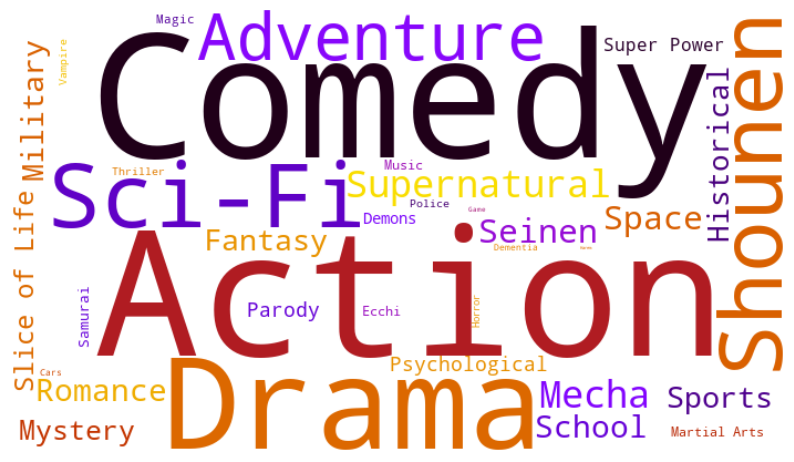

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [79]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [87]:
def get_user_recommendations(similar_users, user_pref, df, sysnopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id), sysnopsis_df)

                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "Genres": genre,
                    "synopsis": synopsis
                })

    return pd.DataFrame(recommended_animes).head(n)

    

In [88]:
similar_users = find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)
user_pref = get_user_preferences(int(11880), rating_df, df)

In [92]:
get_user_recommendations(similar_users, user_pref, df, sysnopsis_df, rating_df, n=1)

,n,anime_name,Genres,synopsis
0,9,Little Witch Academia,"Adventure, Comedy, Fantasy, Magic, School","""A believing heart is your magic!""—these were the words that Atsuko ""Akko"" Kagari's idol, the renowned witch Shiny Chariot, said to her during a magic performance years ago. Since then, Akko has lived by these words and aspired to be a witch just like Shiny Chariot, one that can make people smile. Hence, even her non-magical background does not stop her from enrolling in Luna Nova Magical Academy. However, when an excited Akko finally sets off to her new school, the trip there is anything but smooth. After her perilous journey, she befriends the shy Lotte Yansson and the sarcastic Sucy Manbavaran. To her utmost delight, she also discovers Chariot's wand, the Shiny Rod, which she takes as her own. Unfortunately, her time at Luna Nova will prove to more challenging than Akko could ever believe. She absolutely refuses to stay inferior to the rest of her peers, especially to her self-proclaimed rival, the beautiful and gifted Diana Cavendish, so she relies on her determination to compensate for her reckless behavior and ineptitude in magic. In a time when wizardry is on the decline, Little Witch Academia follows the magical escapades of Akko and her friends as they learn the true meaning of being a witch."


#### HYBRID RECOMMENDER SYSTEM

In [95]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):
    # User recommendation
    similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommended_animes = get_user_recommendations(similar_users, user_pref, df, sysnopsis_df, rating_df)

    user_recommended_anime_list = user_recommended_animes['anime_name'].tolist()

    # Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, sysnopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found for {anime}")

    combined_scores = {}

    print("====================================================================")

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]]

In [96]:
hybrid_recommendation(11880)

Anime closest to Little Witch Academia
Anime closest to Toradora!
Anime closest to Ouran High School Host Club
Anime closest to Code Geass:Lelouch of the Rebellion R2
Anime closest to Darker than Black
Anime closest to Code Geass:Lelouch of the Rebellion
Anime closest to Attack on Titan
Anime closest to Death Note
Anime closest to Spirited Away
Anime closest to Angel Beats!


['Little Witch Academia',
 'Toradora!',
 'Ouran High School Host Club',
 'Code Geass:Lelouch of the Rebellion R2',
 'Darker than Black',
 'Code Geass:Lelouch of the Rebellion',
 'Attack on Titan',
 'Death Note',
 'Spirited Away',
 'Angel Beats!']

In [98]:
hybrid_recommendation(15597)

Anime closest to Bakuman.
Anime closest to D.Gray-man
Anime closest to Naruto
Anime closest to Fate/Zero
Anime closest to Blast of Tempest
Anime closest to Naruto:Shippuden
Anime closest to Fate/Zero Season 2
Anime closest to Maid Sama!
Anime closest to Hellsing Ultimate
Anime closest to Kuroko's Basketball


['Bakuman.',
 'D.Gray-man',
 'Naruto',
 'Fate/Zero',
 'Blast of Tempest',
 'Naruto:Shippuden',
 'Fate/Zero Season 2',
 'Maid Sama!',
 'Hellsing Ultimate',
 "Kuroko's Basketball"]